# Deep Q-Networks

Deep Q-network (DQN) is one of the most popular deep RL algorithms and it started a series of research innovations that mark the history of RL. DQN claimed for the first time **superhuman level performance** on the [**Atari benchmark**](https://gymnasium.farama.org/environments/atari/) in which agents learned from raw pixel data from mere images ([V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](https://arxiv.org/abs/1312.5602) and [V. Mnih, et al. **"Human-level control through deep reinforcement learning"**, Nature 2015](https://doi.org/10.1038/nature14236)).

<img src="./images/atari.png" width="500">

The two problems that consistently show up in the naive application of function approximation to RL (NFQ) are the **violations of the IID assumption** and the **non stationarity of targets**.

In supervised learning, we obtain a full dataset in advance. We pre-process it, shuffle it, and then split it into sets for training. One crucial step in this process is the **shuffling of the data set**. By doing so, we allow our optimization method to avoid developing overfitting biases, reduce the variance of the training process, speed up convergence, and overall learn a more general representation of the underlying data-generating process. In reinforcement learning data is **gathered online** (they come from a sequence, a time series, a trajectory) and the experience sample generated at time step t+1 correlates with the experience sample generated at time step t. Moreover, samples are not identically distributed, because they depend on the policy that generates the actions and the policy is changing through time (it improves).

Also, in supervised learning, the targets used for training are fixed values on our dataset (fixed throughout the training process). In reinforcement learning **targets move with every training step** of the network. At every training update step, we optimize the approximate value function and therefore change the shape of the function, possibly the entire value function. Changing the value function means that the target values change as well, which, in turn, means the targets used are no longer valid. Because the targets come from the network, even before we use them, we can assume targets are invalid or biased at a minimum.

<img src="./images/stationary-problem.png" width="600">

## Target networks

A way to make **target values more stationary** is to have **a separate network** that we can fix for multiple steps and reserve it for calculating more stationary targets. The network with this purpose in DQN is called the **target network**.

<img src="./images/target-network-1.png" width="508"> <img src="./images/target-network-2.png" width="500">

This mitigates the issue of "chasing your own tail" by artificially creating **several small supervised learning problems** presented sequentially to the agent. Targets are fixed for as many steps as we fix our target network. It substantially reduces the chance of divergence. The only difference with NFQ is **the age of the neural network weights**:

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta_i) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

Notice that in practice we don’t have two different networks. The target network is a **previous instance of the same neural network** that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the **online network**, which is the network we optimize on every step.

We can use a network architecture identical to the one used in NFQ:

In [332]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation=F.relu):
        super(FCQ, self).__init__()
        self.activation = activation
        
        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        # connecting the output layer    
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # decide the device to be used
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
            
        # pass it through the input layer
        x = self.activation(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        x = self.output_layer(x)
        
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_failures = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_failures = torch.from_numpy(is_failures).float().to(self.device)
        return states, actions, new_states, rewards, is_failures

By using the target network, we prevent the training process from spiraling around because we’re fixing the targets for multiple time steps, thus allowing the online network weights to move consistently toward the targets before an update changes the optimization problem, and a new one is set. But we also **slow down learning** because you’re no longer training on up-to-date values. It’s essential to **balance stability and speed** by tuning this hyperparameter.

Consider the optimize method of the new algorithm, notice that we use the target network to calculate the Q-values of the next state, but we use the online network to calculate the Q-values of the current state:

In [333]:
def optimize_model(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_failures = experiences
        
    # get the values of the Q-function at next state 
    # this time querying the "target" network 
    # remember to detach, we need to treat these values as constants 
    q_next = self.target_model(next_states).detach()
    # q_next = self.model(next_states).detach() # NFQ
        
    # get the max value of the next state
    max_a_q_next = q_next.max(1)[0].unsqueeze(1)

    # one important step, often overlooked, is to ensure 
    # terminal states are grounded to zero
    max_a_q_next *= (1 - is_failures)
            
    # calculate the target 
    target = rewards + self.gamma * max_a_q_next

    # finally, we get the current estimate of Q(s,a)    
    # notice: here we query the current "online" network
    q = self.online_model(states).gather(1, actions)
    # q = self.model(states).gather(1, actions) # NFQ

    # create the errors
    td_errors = target - q
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

We need one more method to update the target network with the online network weights. We can do this by copying the weights of the online network to the target network:

In [334]:
def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        target.data.copy_(online.data)

## Experience Replay

In NFQ, we use a mini-batch of N samples, and train the network with this batch for K iterations, alternating between calculating new targets and optimizing the network. These N samples are temporally correlated, because most of them belong to the same trajectory. **Experience replay** consists of a data structure (**replay memory**, called D) that **holds M>>N experience samples for several steps**, allowing the **sampling of mini-batches from a broad set of past experiences**. In that way, the training process can use a more diverse mini-batch for performing updates, and the agent no longer has to fit the model to the same small mini-batch for multiple iterations. The replay buffer **gives the impression that data are IID**, so that the optimization method is stable. Samples appear independent and identically distributed because of the sampling from multiple trajectories and even policies at once.

<img src="./images/dqn.png" width="600">

The only difference with previous equation is that **we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D**, instead of using the online experiences as before:

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\max} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

Unfortunately, the **implementation becomes a challenge when working with high-dimensional observations**, because poorly implemented replay buffers hit a **hardware memory limit** quickly. In image-based environments, for instance, where each state representation is a stack of the latest image frames, we probably don’t have enough memory to naively store the experience samples. 

In [335]:
import numpy as np

class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.is_failures = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, is_failure = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.is_failures[self.idx] = is_failure

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.is_failures[idxs])
                      
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

## Exploration strategies

Exploration is a vital component of reinforcement learning. In the NFQ, we use an epsilon-greedy exploration strategy (acting randomly with epsilon probability), however this is not the only possible strategies (see notebook about "Exploration vs Exploitation"). In DQN, we use a **Exponentially decaying epsilon-greedy exploration strategy**. We start with a high epsilon value, and we exponentially decay it over time. This strategy allows the agent to explore the environment more at the beginning of the training process, and exploit it more at the end. It is simple and works well. But other, more advanced, strategies may be worth trying. Notice that even a small difference in hyper-parameters, can make a significant difference in performance. 

In [336]:
class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):        
        with torch.no_grad():
            # pulling out the Q-values for state s
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        return action


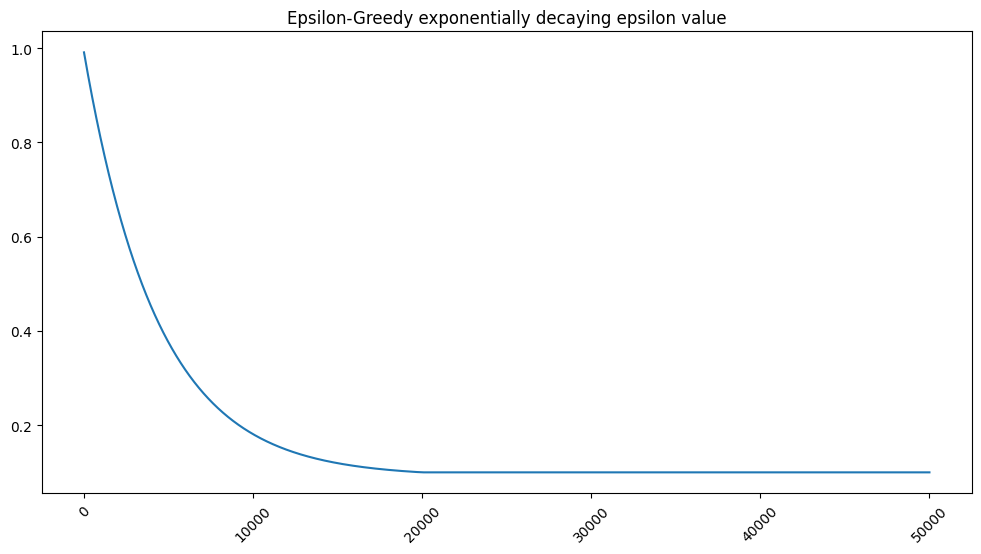

In [337]:
import matplotlib.pyplot as plt

s = EGreedyExpStrategy()

plt.figure(figsize=(12,6))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)

plt.show()

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function. This means that we will always select the action that maximizes the action-value function, without any exploration. This is because we want to evaluate the agent’s performance, and not the exploration strategy.

In [338]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            # pulling out the Q-values for state s
            q_values = model(state).detach().data.numpy().squeeze()
        
        # act greedily
        return np.argmax(q_values)

## Deep Q-network (DQN) 

We can now implement the full DQN algorithm, the main difference with NFQ are that we use an exponentially decaying epsilon-greedy strategy to improve policies, we use a replay buffer and a target network. So the algorithm has three main steps:

1. collect experience and insert it into the replay memory
2. randomly sample a mini-batch from the buffer, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [339]:
import random 
import torch
import torch.optim as optim

class DQN():
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 n_warmup_batches, target_update_steps):        
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

We add the "optimize_model" method with the target and online networks, and the "update_target_model" method to update the target network weights:

In [340]:
DQN.optimize_model = optimize_model
DQN.update_network = update_network

Then, we need a new interaction step method that uses the **online network to explore the environment** and the **reply buffer to collected experiences**:

In [341]:
def interaction_step(self, state):
    
    # interact with environment using the exploration policy
    # notice how we use the online model for selecting actions
    action = self.train_strategy.select_action(self.online_model, state)
    # action = self.train_strategy.select_action(self.model, state) # NFQ

    # collect an experience tuple as usual    
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

    # a failure is defined as follows
    is_failure = is_terminal and not is_truncated
    
    # collect the experience and store it in the replay buffer, no more in the batch
    experience = (state, action, reward, new_state, float(is_failure))
    self.replay_memory.store(experience)
    # self.experiences.append(experience) # NFQ

    # update episode stats
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1

    # define the end of the episode as terminated or truncated
    is_done = is_terminal or is_truncated
    
    return new_state, is_done

DQN.interaction_step = interaction_step

As in NFQ, need a method to evaluate the learned policy using a greedy strategy, in that case, we use the online network:

In [342]:
def evaluate(self, n_episodes=1, greedy=True):

    # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment
        s = self.env.reset()[0]

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the exploitation policy
            a = self.eval_strategy.select_action(self.online_model, s)

            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

            # add the reward to the return of the episode
            rs[-1] += r

            if d or t:
                break
        
    return np.mean(rs), np.std(rs)

DQN.evaluate = evaluate

Finally, we need to write the new training loop, the difference with NFQ are that **we need to sample a mini-batch from the replay memory**, we never need to use the same mini-batch for multiple epochs and **sometimes we have to synchronize the target network with the online network**:

In [343]:
from itertools import count
import time

def train(self, gamma, max_minutes, max_episodes, goal_reward, episodes_window):
        
        # timing variables
        training_start = time.time()
        training_time = 0

        self.gamma = gamma

        # stats trackers 
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        
        # we synchronize the online and target models at the beginning of training
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan

        # train until we either reach the max minutes, the max episodes or the goal mean reward
        for episode in range(1, max_episodes + 1):

            # get the start time of the episode
            episode_start = time.time()
            
            # reset the episode trackers
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            # reset the environment before starting the episode
            state = self.env.reset()[0]

            # interact with the environment until the episode is done
            for step in count():

                # interact with environment using the exploration policy
                # and collect the experience in the replay memory
                state, is_done = self.interaction_step(state)
                
                # if the replay memory has enough samples, we can create 
                # the mini-batch and optimize the model 
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:

                    # load the experiences as tensors for training from the replay memory
                    experiences = self.replay_memory.sample()
                    # experiences = np.array(self.experiences, dtype=object) # NFQ
                    experiences = self.online_model.load(experiences)

                    # optimize the model
                    self.optimize_model(experiences)
                
                # synchronize the target model with the online model
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_done:
                    break

            # timing stuff
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            # episode steps count
            total_step = int(np.sum(self.episode_timestep))

            # evaluate the learned policy after the episode
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            # average stats over some recent episodes
            mean_train_reward = np.mean(self.episode_reward[-episodes_window:])
            std_train_reward = np.std(self.episode_reward[-episodes_window:])
            mean_eval_score = np.mean(self.evaluation_scores[-episodes_window:])
            std_eval_score = np.std(self.evaluation_scores[-episodes_window:])

            # report results
            result[episode-1] = total_step, mean_train_reward, mean_eval_score, training_time
            
            # check max episodes, max minutes and goal achievement criteria
            total_elapsed = time.time() - training_start
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_eval_score >= goal_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            # informative print logging  
            debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
            debug_message = debug_message.format(episode, total_step, mean_eval_score, std_eval_score)
            print(debug_message, end='\r', flush=True)
            
            # conclude training if we have met any of the stopping conditions
            if training_is_over:
                print(debug_message)
                if reached_max_minutes: print(u'--> reached_max_minutes ')
                if reached_max_episodes: print(u'--> reached_max_episodes ')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
                break
                
        # evaluate the final policy
        final_eval_score, final_eval_std = self.evaluate(n_episodes=episodes_window)
        
        return result, final_eval_score, final_eval_std, training_time
    
DQN.train = train


We can show the performance of DQN on the cart-pole environment in order to show that it is more powerful than NFQ. We can also show that the target network and the replay buffer are important for the stability of the algorithm.

In [344]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1')

We write a function to manage the experiment for all algorithms:

In [345]:
def experiment(algorithm, network, env, gamma=1, 
               max_minutes=20, max_episodes=10000, goal_reward=475, episodes_window=25,
               hidden_dims=(512,128), learning_rate=0.0005,
               replay_memory_max_size=50000, replay_memory_batch_size=64,
               init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000,
               target_update_steps=10, n_warmup_batches=5,
               seeds=(12, 34, 56, 78, 90)):
    
    results = []
    best_agent = None 
    best_eval_score = float('-inf')
    
    for seed in seeds:
        print('Training started...')

        # set the seeds for reproducibility of results
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.np_random = np.random.Generator(np.random.PCG64(seed))

        # create models, optimizer, reply buffer and strategies
        nS, nA = env.observation_space.shape[0], env.action_space.n
        online_model = network(nS, nA, hidden_dims)
        target_model = network(nS, nA, hidden_dims)
        optimizer = optim.RMSprop(online_model.parameters(), lr=learning_rate)
        replay_memory = ReplayMemory(max_size=replay_memory_max_size, batch_size=replay_memory_batch_size)
        train_strategy = EGreedyExpStrategy(init_epsilon=init_epsilon, min_epsilon=min_epsilon, decay_steps=decay_steps)
        eval_strategy = GreedyStrategy()

        # create the agent
        agent = algorithm(env, online_model, target_model, optimizer, 
                          train_strategy, eval_strategy, replay_memory, 
                          n_warmup_batches, target_update_steps)

        # train the agent
        result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward, episodes_window)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent

        print('...training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))

    return np.array(results), best_agent, best_eval_score

Then we run the experiment for the DQN agent:

In [346]:
dqn_results, dqn_agent, dqn_score = experiment(DQN, FCQ, cartpole)

Training started...
episode 0180, steps 025592, avg eval score 479.2 (+/- 065.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 28.26s training time

Training started...
episode 0222, steps 028453, avg eval score 476.0 (+/- 067.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 31.32s training time

Training started...
episode 0172, steps 020648, avg eval score 476.3 (+/- 053.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 467.72±59.09 in 22.27s training time

Training started...
episode 0199, steps 026942, avg eval score 475.1 (+/- 066.8)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 30.75s training time

Training started...
episode 0224, steps 029191, avg eval score 481.7 (+/- 061.4)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 32.38s training time



We can load the results of NFQ in order to compare the performances of the two algorithms:

In [347]:
nfq_results = np.load('nfq_results.npy')

We write several functions to show the training reward, the evaluation reward, the total time steps and the training time for each episode:

In [348]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

From the following graph of the average rewards, we can draw the conclusion that DQN is **more sample efficient** than NFQ. But, paying attention to the curves, we notice how NFQ is also **noisier** than DQN. This is one of the most important improvements we accomplished so far.

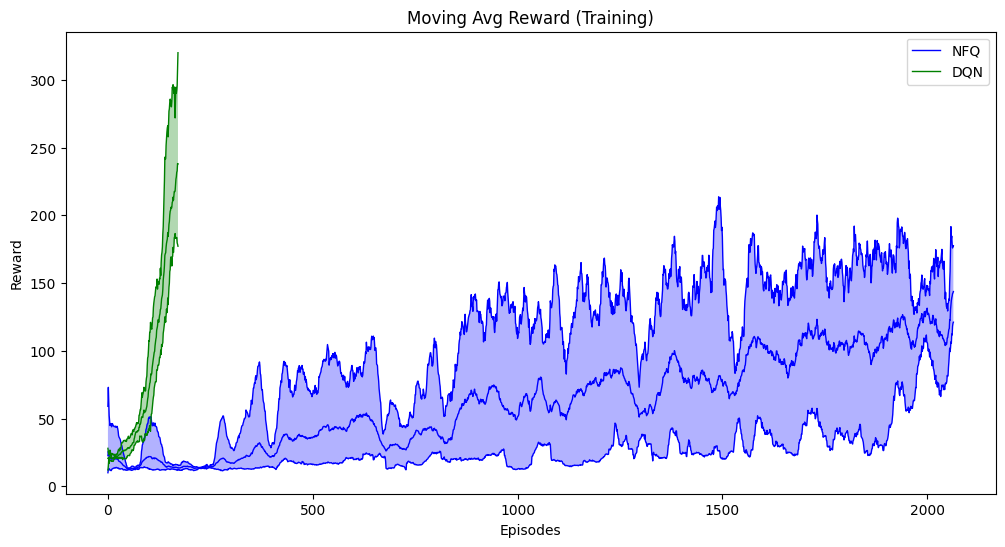

In [349]:
show_result('avg_training_reward','NFQ', nfq_results, 'DQN', dqn_results) 

We can plot the average reward obtained in evaluation for each episode. Notice that both algorithms pass the cartpole environment, but DQN takes approximately one order of magnitude less episodes to do so. Again, this is because DQN is more sample efficient than NFQ.  


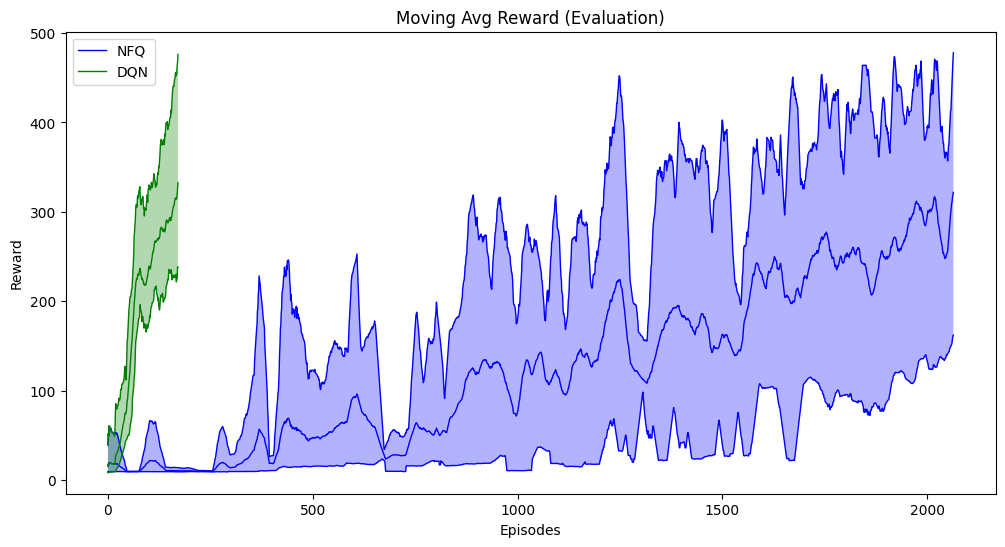

In [350]:
show_result('avg_evaluation_reward','NFQ', nfq_results, 'DQN', dqn_results) 

We can plot the total number of steps to see a similar trend in sample efficiency:

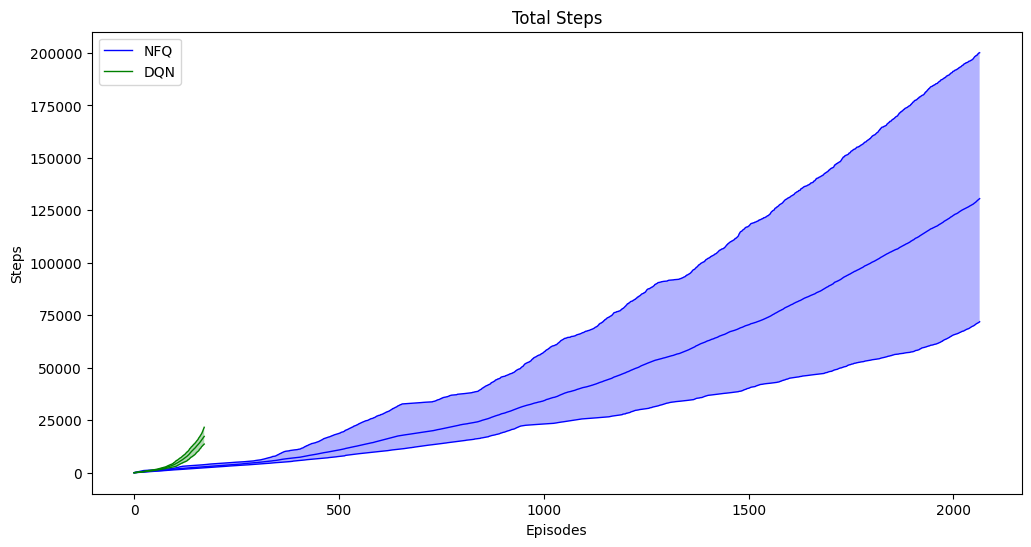

In [351]:
show_result('total_steps','NFQ', nfq_results, 'DQN', dqn_results) 

Finally, we can plot the training time for each episode. Notice that DQN is slower than NFQ, this is because we need to sample a mini-batch from the replay buffer and sometimes we need to synchronize the target network with the online network. However, the training time is still reasonable.

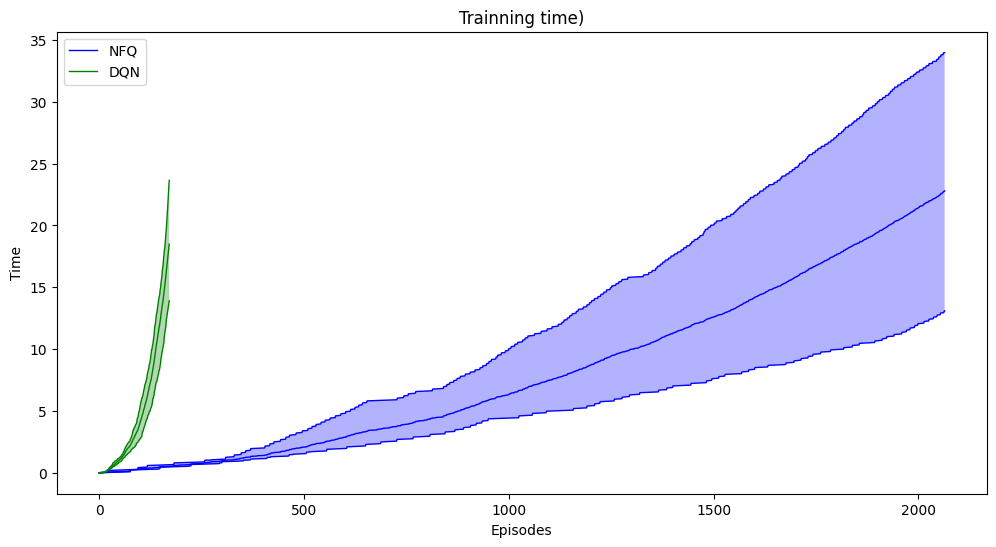

In [352]:
show_result('training_time','NFQ', nfq_results, 'DQN', dqn_results) 

## Double DQN

In general, Q-learning **tends to overestimate action-value functions**, and the DQN agent is no different, we’re using the same off-policy TD target with the max operator. The problem is simple, we’re taking the max of estimated values and estimated values are often off-center, some higher than the true values, some lower, but the bottom line is that they’re off and we’re always taking the max of these values, so we have a preference for higher values, even if they aren’t correct. Our algorithms show a **positive bias**, and performance suffers. One way to better understand positive bias and how we can address it when using function approximation is by unwrapping the max operator in the target calculations: 

$\displaystyle
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a'}{\text{ max }} Q(s',a';\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

notice that the max of a Q-function is the same as the Q-function of the argmax action:

$\displaystyle
\underset{a'}{\text{ max }} Q(s',a';\theta^-) = Q(s',\underset{a'}{\text{argmax }} Q(s',a';\theta^-);\theta^-) $

so we can modify the gradient expression as

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma  Q(s',\underset{a'}{\text{argmax }} Q(s',a';\theta^-);\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

There’s no real difference between the two equations, since both are using the same Q-values for the target. All we’re saying here is that taking the max is like asking the network "What’s the value of the highest-valued action in state s?" But, we are really asking two questions with a single question. First, we do an argmax, which is equivalent to asking, "Which action is the highest-valued action in state s?" and then, we use that action to get its value, equivalent to asking, "What’s the value of this action in state s?" One of the problems is that **we are asking both questions to the same Q-function, which shows bias in the same direction in both answers**. In other words, the function approximator will answer, "I think this one is the highest-valued action in state s, and this is its value". 

An idea to reduce the chance of positive bias is to have **two instances of the action-value function** ([van Hasselt et al. **"Deep Reinforcement Learning with Double Q-learning"** (2015) AAAI Conference](https://arxiv.org/abs/1509.06461v3)), so we can ask one of the questions to one and the other question to the other. It’s somewhat like getting a second doctor’s opinion on health matters. In double learning, **one estimator selects the index of what it believes to be the highest-valued action, and the other estimator gives the value of this action**.

Implementing this procedure creates **unnecessary overhead** (we end up with four networks, two for training and two target networks) and it creates a **slowdown in the training process** (since we’d be training only one of these networks at a time). Fortunately, there’s a simple modification to the original double-learning procedure that adapts it to DQN and gives us substantial improvements without the extra overhead: **we can perform double learning with the other network we already have, which is the target network**. We use the online network (the network we’re training) for answering the first question (to find the index of the best action), then we use the target network to ask the second question (evaluate the selected action):

<img src="./images/ddqn.png" width="600">

So, the only difference in DDQN gradient expression is that now we use the online weights to select the action, but still use the frozen weights to get the estimate:

$\displaystyle
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma Q(s',\underset{a'}{\text{argmax }} Q(s',a';\theta_i);\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right] $

In [353]:
def optimize_model_ddqn(self, experiences):

    # convert the experiences into separate arrays for each element
    states, actions, rewards, next_states, is_failures = experiences

    # get the values of the Q function using the target and online network at next state
    # remember to detach, we need to treat these values as constants 
    q_online_next = self.online_model(next_states).detach()
    q_target_next = self.target_model(next_states).detach()

    # unwrap the max     
    argmax_a_q_online_next = q_online_next.max(1)[1].unsqueeze(1)
    q_target_next_max = q_target_next.gather(1, argmax_a_q_online_next)
    q_target_next_max *= (1 - is_failures)
    
    # calculate the target 
    target = rewards + self.gamma * q_target_next_max

    # finally, we get the current estimate of Q(s,a)    
    q_online = self.online_model(states).gather(1, actions)

    # create the errors
    td_errors = target - q_online
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()

    self.optimizer.zero_grad()
    value_loss.backward()    
    self.optimizer.step()

We can put all things together and write the DDQN network, which is almost identical to DQN:

In [354]:
class DDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 n_warmup_batches, target_update_steps):
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

In [355]:
DDQN.optimize_model = optimize_model_ddqn
DDQN.interaction_step = interaction_step
DDQN.update_network = update_network
DDQN.evaluate = evaluate
DDQN.train = train

DDQN and DQN have similar performance in the cart-pole environment. However, this is a
simple environment with a smooth reward function. In real problems, DDQN should always give better performance.

In [356]:
ddqn_results, ddqn_agent, ddqn_score = experiment(DDQN, FCQ, cartpole)

Training started...
episode 0217, steps 031931, avg eval score 480.1 (+/- 068.1)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 37.57s training time

Training started...
episode 0240, steps 034416, avg eval score 478.1 (+/- 074.8)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 40.92s training time

Training started...
episode 0211, steps 029165, avg eval score 480.6 (+/- 052.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 33.73s training time

Training started...
episode 0180, steps 021735, avg eval score 476.7 (+/- 062.6)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 24.23s training time

Training started...
episode 0234, steps 040317, avg eval score 482.9 (+/- 058.2)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 48.93s training time



Pay attention not to the mean lines in the middle, but to the top and bottom bounds representing the maximum and minimum values obtained by any of the five seeds during that episode. DDQN shows **tighter bounds**, basically, showing more stability on performance.

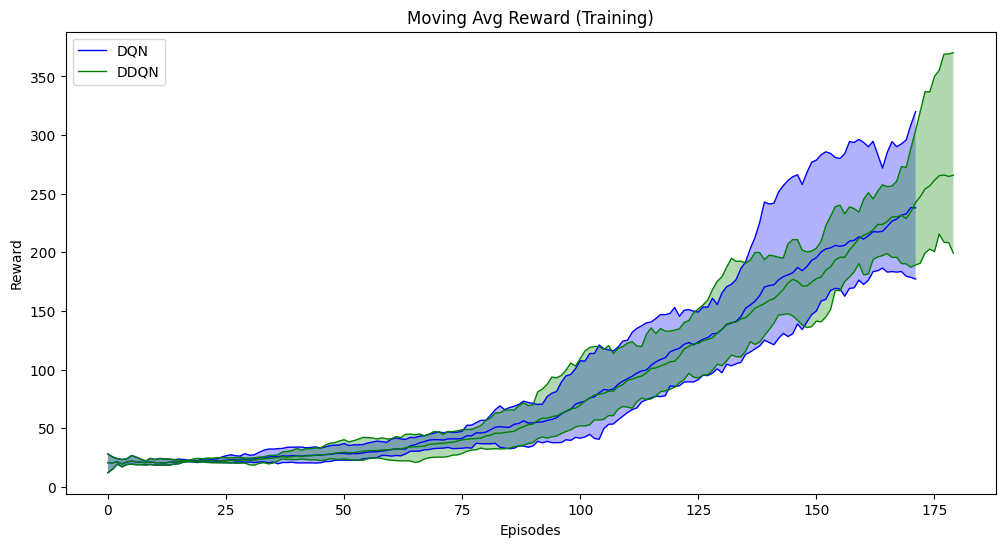

In [357]:
show_result('avg_training_reward','DQN', dqn_results, 'DDQN', ddqn_results) 

We see he same pattern: DDQN has narrower bounds. In terms of performance, DDQN **reaches the max in fewer episodes** and reaches the max in a similar number of episodes across all seeds: **stability**

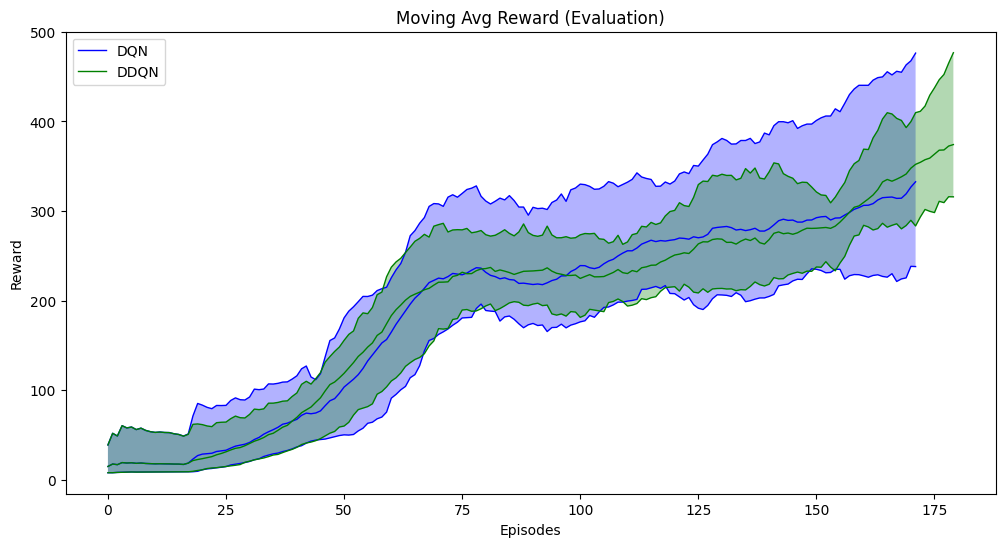

In [358]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'DDQN', ddqn_results) 

In this case, DDQN goes in a similar way.

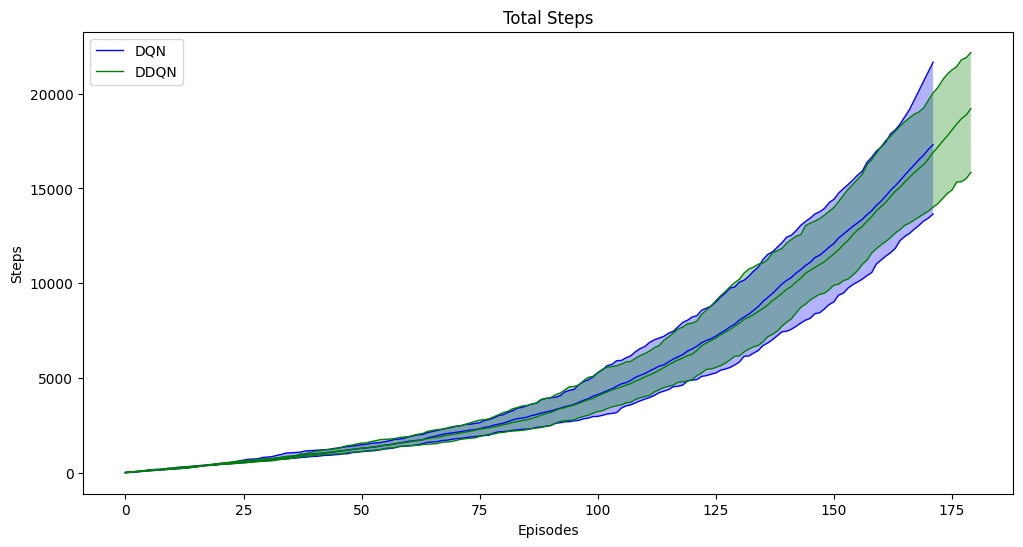

In [359]:
show_result('total_steps','DQN', dqn_results, 'DDQN', ddqn_results) 

In terms of time, DDQN take **a bit longer** than DQN to successfully pass the environment.

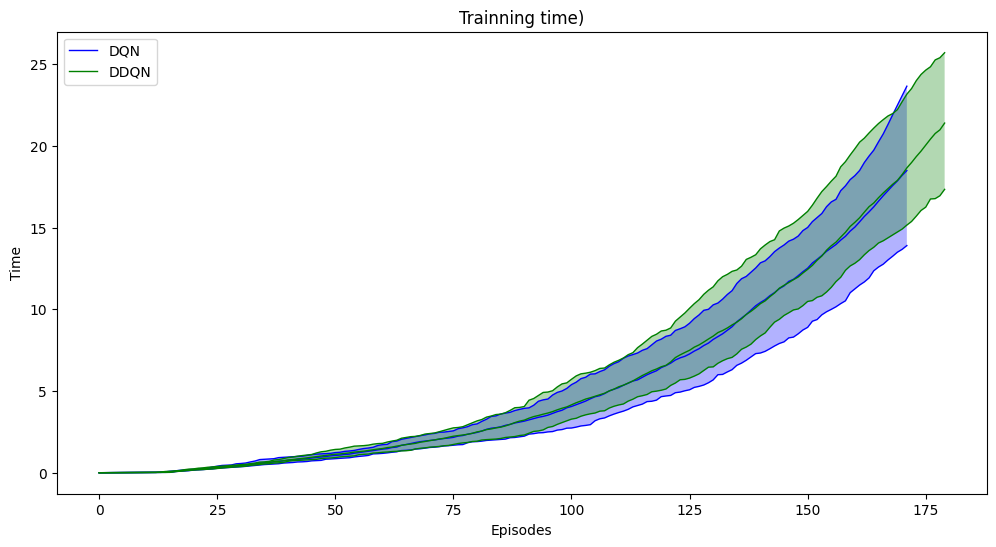

In [360]:
show_result('training_time','DQN', dqn_results, 'DDQN', ddqn_results) 

## Dueling DDQN

The dueling network is an improvement that applies to the **network architecture** and not the algorithm. Until now, we concentrated our efforts on making reinforcement learning **look more like a supervised learning problem**: using the replay memory we made data more like an independent and identically distributed dataset; using two networks we made targets look more static. This helps stabilize training, but ignoring the fact that reinforcement learning problems are problems of their own isn’t the smartest approach to solving these problems.

Now we try to exploit the subtleties of value-based deep reinforcement learning agents, in particular the way the value functions relate to one another. More specifically, we can use the fact that the state-value function V and the action-value function Q are related to each other through the **action-advantage function** A:

$\displaystyle v_{\pi}(s) = E_{\pi}[G_t | S_t=s] $

$\displaystyle q_{\pi}(s,a) = E_{\pi}[G_t | S_t=s, A_t=a] $

we can define the **action-advantage function** as the **difference between the value of taking an action in a state and the value of choosing the policy action**:

$\displaystyle a_{\pi}(s,a) = q_{\pi}(s,a) - v_{\pi}(s) $

We can rewrite this and observe that the action-value function can be defined as the sum of the state-value function and the action-advantage function. This means that we can decompose the action-value function into two components: **one shared across all actions, and another unique to each action**:

$\displaystyle q_{\pi}(s,a) = v_{\pi}(s) + a_{\pi}(s,a) $


This means that we’re learning the action-value function inefficiently, because **some information is shared between the nodes of a network**. However, when learning about the action-value of an action, we’re ignoring the fact that we could use the same information to learn something about all other actions:

<img src="./images/dueling.png" width="800">

The bottom line is that **the values of actions depend on the values of states**, and it would be nice to leverage this fact. In the end, taking the worst action in a good state could be better than taking the best action in a bad state. Considering the following example from cart-pole to better understand the importance of the action-advantage function:

<img src="./images/action-advantage.png" width="800">


The **dueling network architecture** ([Ziyu et al. **Dueling Network Architectures for Deep Reinforcement Learning**, ICML 2016](https://arxiv.org/abs/1511.06581)) consists of creating two separate estimators: one of the state-value function, and the other of the action-advantage function. We can use a single network sharing most of the internal nodes and layers, the layer before the output splits into two streams: a stream for the state-value function and another for the action-advantage function. The V-function output layer always ends in a single node because the value of a state is always a single number, the output layer for the Q-function, however, outputs a vector of the same size as the number of actions:

<img src="./images/dueling-network.png" width="800">

Now, we need to find a way to **aggregate the two outputs from the network** and reconstruct the action-value function. How do we join the outputs? Some of you are thinking, add them up, right?  The Q-function is parameterized by theta (weights of the shared layers), alpha (weights of the action-advantage function stream), and beta (weights of the state-value function stream):

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha) $

However, notice that we cannot uniquely recover the Q from V and A (think about it: if we add +10 to V and remove it from A we obtain the same Q with two different values for V and A), we use the above equation in practice. The way to address this issue is by subtracting the mean of the advantages from the aggregated action-value function estimate. Doing this stabilizes the optimization process:

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \left( A(s,a;\theta,\alpha) - \frac{1}{|A|}\sum\limits_{a'}{A(s,a;\theta,\alpha)} \right) $

In [361]:
class FCDuelingQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation=F.relu):
        super(FCDuelingQ, self).__init__()
        self.activation = activation

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        
        # creating the hidden layers  
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # finally, we build the two output layers, both connected to the last hidden layer 

        # the value_output has a single node output 
        self.value_output = nn.Linear(hidden_dims[-1], 1)
       
        # the advantage_output has output_dim nodes
        self.advantage_output = nn.Linear(hidden_dims[-1], output_dim)

        # decide the device to be used
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

            
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)
 
        # pass it through the input layer
        x = self.activation(self.input_layer(x))
        
        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        
        # then pass for the advantage_output and the value_output layers. 
        a = self.advantage_output(x)
        v = self.value_output(x)
        
        # finally, add v and a and subtract the mean of a from it
        q = v + (a - a.mean())
        
        return q

    def load(self, experiences):
        states, actions, new_states, rewards, is_failures = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_failures = torch.from_numpy(is_failures).float().to(self.device)
        return states, actions, new_states, rewards, is_failures

The rest of the architecture of the Dueling DDQN is almost identical to DDQN: the network outputs the action-value approximation, an off-policy TD target is used to evaluate policies, the loss is evaluated with the Huber formula, a replay memory is used to learning from past experiences, the optimizer is the RMSprop, an exponentially decaying epsilon-greedy strategy is used to improve policies and a greedy action selection strategy for the evaluation step.

However, the **DDQN agent use a target network that can be outdated for several steps before it gets a weight update** when syncing with the online network. There are a couple of issues with this approach: on the one hand, we’re freezing the weights for several steps and calculating estimates with progressively increasing stale data; on the other hand, a huge update is made to the network, making a big update that changes the whole landscape of the loss function all at once. **This update style seems to be both too conservative and too aggressive at the same time**. Of course, we got into this issue because we wanted our network not to move too quickly and therefore create instabilities.

We can have similar results, but in a smooth manner: we can **slow down the target network instead of freezing it**. This technique is called **Polyak Averaging**, and it consists of mixing online network weights into the target network on every step. We create a new target network composed of a large percentage of the target network weights and a small percentage of the online network weights. In that way, the target network always lags, but by a much smaller gap.

So, instead of making the target network equal to the online network every N time steps, we mix the target network with a tiny bit of the online network more frequently (even every time step):

$\displaystyle \theta_i^- = \tau \theta_i + (1-\tau)\theta_i^- $

$\displaystyle \alpha^- = \tau \alpha_i + (1-\tau)\alpha_i^- $

$\displaystyle \beta_i^- = \tau \beta_i + (1-\tau)\beta_i^- $

where $\tau$ is the **mixing factor**.

In [362]:
def update_network_dueling(self, tau=0.1):  
    
    # variable representing the ratio of the online network that will
    # be mixed into the target network
    tau = self.tau if tau is None else tau
    
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        # calculate the ratios we’re taking from the target and online weights
        target_ratio = (1.0 - tau) * target.data
        online_ratio = tau * online.data
        
        # mix the weights and copy the new values into the target network 
        mixed_weights = target_ratio + online_ratio
        target.data.copy_(mixed_weights)

In [363]:
class DuelingDDQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 n_warmup_batches, target_update_steps):
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

In [364]:
DuelingDDQN.optimize_model = optimize_model_ddqn
DuelingDDQN.interaction_step = interaction_step
DuelingDDQN.update_network = update_network_dueling
DuelingDDQN.evaluate = evaluate
DuelingDDQN.train = train

Dueling DDQN and DDQN have similar performance in the cart-pole environment. Dueling DDQN is slightly more data efficient. The number of samples DDQN needs to pass the environment is higher than that of dueling DDQN. However, dueling DDQN takes slightly longer than DDQN.

In [365]:
dueling_ddqn_results, dueling_ddqn_agent, dueling_ddqn_score = experiment(DuelingDDQN, FCDuelingQ, cartpole, target_update_steps=1)

Training started...


episode 0183, steps 022805, avg eval score 477.2 (+/- 052.5)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 460.92±71.38 in 30.91s training time

Training started...
episode 0285, steps 045656, avg eval score 478.6 (+/- 061.5)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 69.48s training time

Training started...
episode 0264, steps 044974, avg eval score 478.1 (+/- 052.1)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 66.48s training time

Training started...
episode 0280, steps 059656, avg eval score 481.0 (+/- 048.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 483.48±39.65 in 91.40s training time

Training started...
episode 0325, steps 058789, avg eval score 475.5 (+/- 051.5)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 90.44s training time



The training curves of dueling DDQN are narrower and end sooner than DDQN. This suggests that dueling DDQN isn’t only learning in fewer samples, but also learning more stable policies.

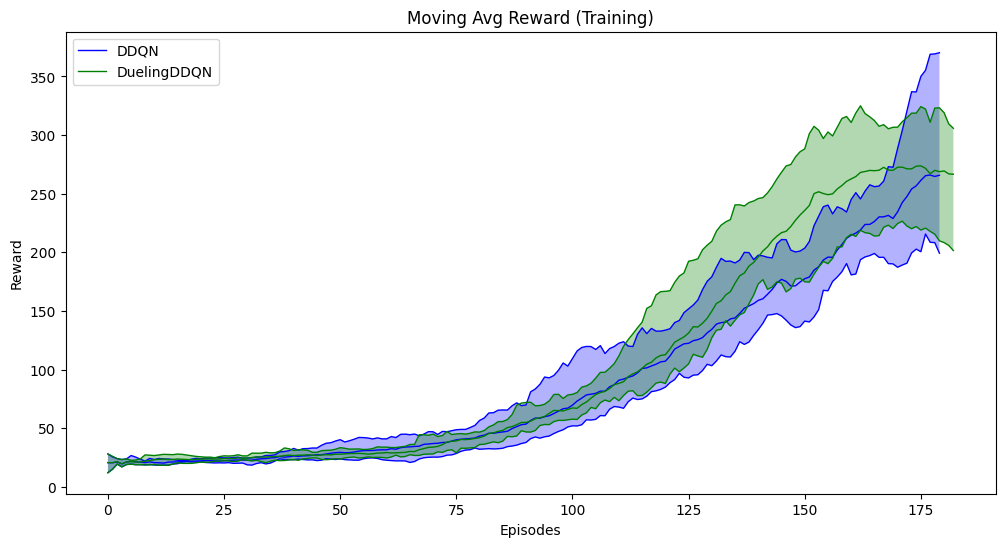

In [366]:
show_result('avg_training_reward','DDQN', ddqn_results, 'DuelingDDQN', dueling_ddqn_results) 

The evaluation plot shows the same pattern.

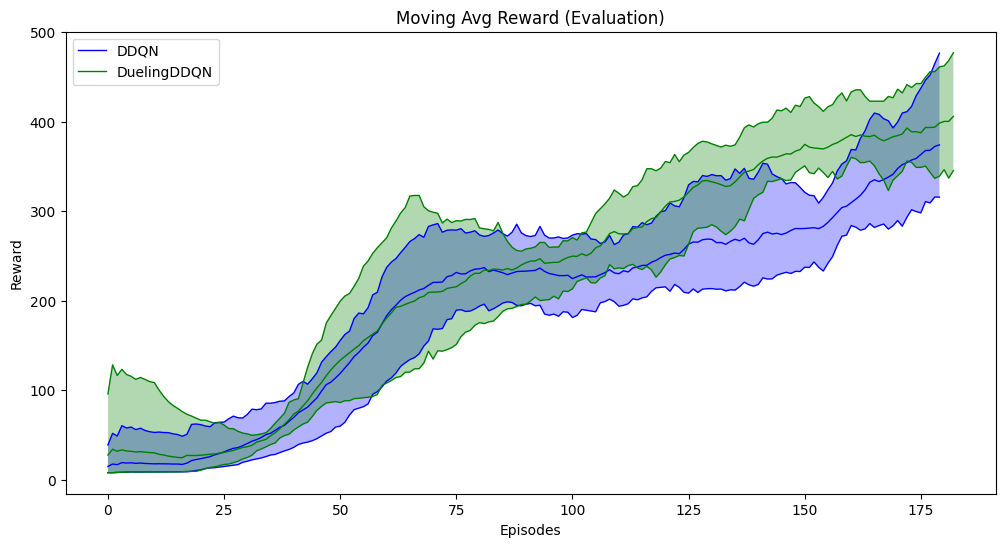

In [367]:
show_result('avg_evaluation_reward','DDQN', ddqn_results, 'DuelingDDQN', dueling_ddqn_results) 

Dueling DDQN consumes less data and fewer steps.

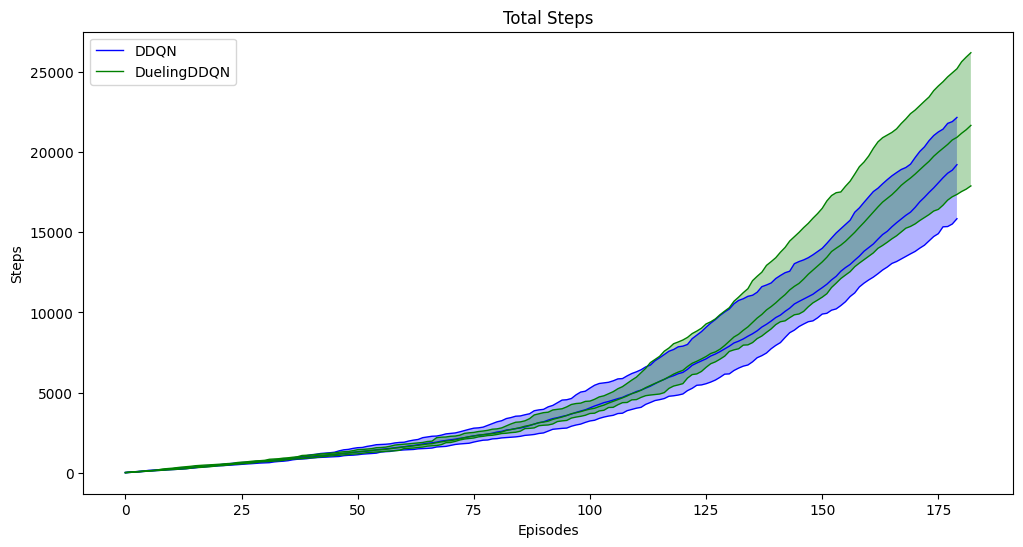

In [368]:
show_result('total_steps','DDQN', ddqn_results, 'DuelingDDQN', dueling_ddqn_results) 

But it takes longer to train. Maybe because we’re now updating the target network
every time step? Maybe the dueling network? Experiment and find out!

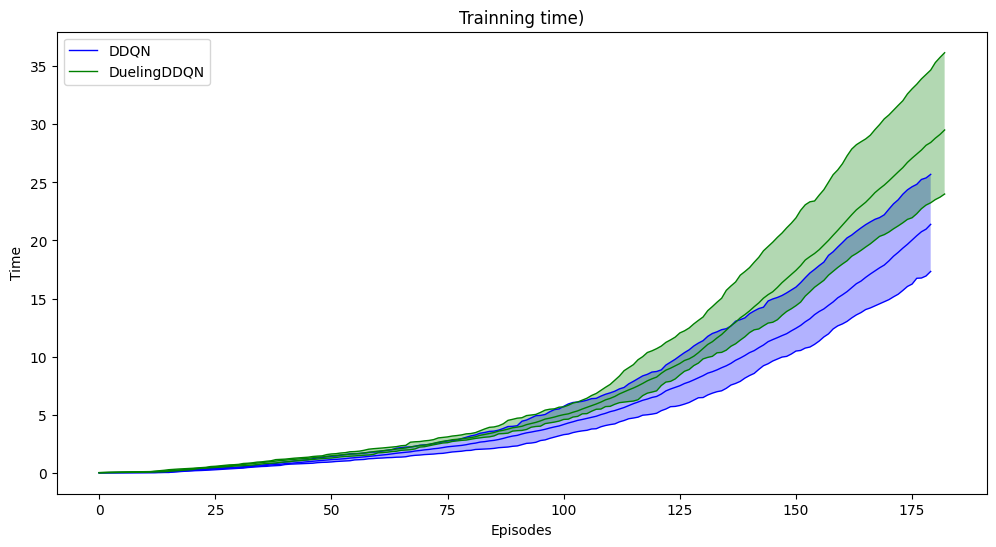

In [369]:
show_result('training_time','DDQN', ddqn_results, 'DuelingDDQN', dueling_ddqn_results) 

## PER: Prioritized Experience Replay

The agent samples experience tuples from the replay memory uniformly at random. Intuitively, this seems like an inferior way of replaying experiences. It doesn’t feel right that the agent spends time and compute power "learning" things that have nothing to offer to the current state of the agent. But, while this is evident, more difficult is determining a different sampling behavior. We can think that since the agent has to get the highest cumulative discounted rewards possible, we can replay experiences with high reward only. However, this obvious approach didn’t work. The agent needs also other types of experiences! What we’re looking for is **to learn from experiences with unexpected value (surprising experiences)**. The agent has a view of the world, he anticipates outcomes, and when the difference between expectation and reality is significant, we know he can learn something from that! In reinforcement learning, this **measure of surprise** is given by the TD error: it provides the difference between the agent’s current estimate and target value. The absolute difference between these values **indicates how unexpected this experience is**, and how much new information the agent receives, which makes it a good indicator for learning opportunity ([Tom Schaul et al. **Prioritized Experience Replay** ICLR 2016](https://arxiv.org/abs/1511.05952?context=cs)):

$\displaystyle |\delta_i| = |r + \gamma Q\left(s', \underset{a'}{\arg \max}\text{ } Q\left(s',a';\theta_i \right);\theta^-, \right)-Q\left(s,a;\theta_i, \right) |$

We can  **insert experience into the replay memory as a tuple containing also to the TD error**, so then we can pull out the top experiences from the buffer **sorting** by this new value. However there two issues with this approach: first, we are calculating the TD errors twice (before inserting it into the memory, and then again when we train the network); second we’re ignoring the fact that TD errors change every time the network changes, because they’re calculated using the network. The solution can’t be updating all of the TD errors every time step, it’s simply not cost effective.

A workaround for both these problems is to **update the TD errors only for experiences that are used to update the network (the replayed experiences)** and insert new experiences with the highest magnitude TD error in the memory. However, other issues arise: a TD error of zero in the first update means that experience will likely never be replayed again, moreover when using function approximator, errors shrink slowly, and this means that updates concentrate heavily in a small subset of the replay memory. For these reasons, we need a strategy for sampling experiences based on the TD errors, but **stochastically, not greedily**: in that way we can simultaneously ensure all experiences have a chance of being replayed, and that the probabilities of sampling experiences are monotonic in the absolute TD error.

First we calculate priorities for each sample in the buffer based on TD errors:

$\displaystyle p_i = |\delta_i| + \epsilon $

we add a small constant, epsilon, to make sure zero TD error samples still have a chance of being replayed. A slightly different prioritization approach is to sample them using the rank (position of the sample)  of the samples when sorted in descending order by their absolute TD error:

$\displaystyle p_i = \frac{1}{\text{rank}(i)} $

Then, we scale the priority by exponentiating it to a hyperparameter alfa that allows us to interpolate between uniform and prioritized sampling:

$\displaystyle P(i)=\frac{p_i^\alpha}{\sum\limits_{k}{p_k^\alpha} } $

When alpha is zero, all values become one, therefore, an equal priority; when alpha is one, all values stay the same as the absolute TD error; a value in between blends the two sampling strategies. The scaled priorities are converted to actual probabilities by dividing by the sum of the values. 

One issue with this approach is that it’s sensitive to outliers. That means experiences with much higher TD error than the rest (whether by fact or noise) are sampled more often than those with low magnitudes, which may be an undesired side effect.

Another problem is that the prioritization introduces a form of **sampling bias toward high-priority samples** (more chances to be selected). With prioritization we are not uniformly sampling from the replay memory and we start over-sampling those with high priority. We must compensate for this bias during training or the model will just overfit the important experiences. To be clear, **we want important experiences to be sampled more often, but this also means we must give them a lower weight during training**. The way to mitigate this bias is to use a technique called **weighted importance sampling**: it consists of scaling the TD errors by weights calculated with the probabilities of each sample. We can calculate the importance-sampling weights by multiplying each probability by the number N of samples in the replay buffer:

$\displaystyle w_i = \left(\frac{1}{N} \frac{1}{P_i}\right)^\beta $

we add the beta hyperparameter to tune the degree of the corrections. When beta is zero, there’s no correction; when beta is one, there’s a full correction of the bias. Training is highly unstable at the beginning, so the importance sampling corrections matter more near the end of training. Thus, beta starts small (values of 0.4 to 0.6 are commonly used) and anneals towards one.

Additionally, we want to normalize the weights by their max so that the max weight becomes one, and all other weights scale down the TD errors. This way, we keep TD errors from growing too much and keep training stable:

$\displaystyle w_i = \frac{w_i}{max_j(w_j)} $

These importance-sampling weights are used in the loss function. Instead of using the TD
errors straight in the gradient updates, we multiply them by the importance-sampling weights: 

$\displaystyle \nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim P(D)} \left[ w \left( r + \gamma Q\left(s',\underset{a'}{\arg \max} Q\left(s',a';\theta_i\right);\theta^-\right) - Q\left(s,a;\theta_i\right)\right) \nabla_{\theta_i} Q\left(s,a;\theta_i\right) \right] $

Notice how we’re using the normalized importance-sampling weights to modify the magnitude of the TD error, and that we changed the "U" for a "P", because we’re doing a prioritized sampling, and not uniformly at random.

In [370]:
class PrioritizedReplayMemory():
    def __init__(self, max_samples=10000, batch_size=64, 
                 alpha=0.6, beta0=0.1, beta_rate=0.99992):
        self.max_samples = max_samples
        self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
        self.batch_size = batch_size
        self.n_entries = 0
        self.next_index = 0
        self.td_error_index = 0
        self.sample_index = 1
        self.alpha = alpha 
        self.beta = beta0
        self.beta0 = beta0
        self.beta_rate = beta_rate

    def store(self, sample):
        
        # calculate the priority for the sample
        priority = 1.0
        if self.n_entries > 0:
            priority = self.memory[:self.n_entries, self.td_error_index].max()
            
        # insert the sample and its priority into the memory
        self.memory[self.next_index, self.td_error_index] = priority
        self.memory[self.next_index, self.sample_index] = np.array(sample, dtype=object)
        
        # increase the variable that indicates the number of experiences in the buffer
        self.n_entries = min(self.n_entries + 1, self.max_samples)
        
        # calculare index at which the next experience will be inserted
        # this variable loops back around from max_samples to 0 and goes back up
        self.next_index += 1
        self.next_index = self.next_index % self.max_samples
    
    def update(self, idxs, td_errors):
        # takes the array of experiences ids, and new TD error values
        # insert the absolute TD errors into the right place.
        self.memory[idxs, self.td_error_index] = np.abs(td_errors)

    def _update_beta(self):
        self.beta = min(1.0, self.beta * self.beta_rate**-1)
        return self.beta

    def sample(self, batch_size=None):
        
        # Calculate the batch_size
        batch_size = self.batch_size if batch_size == None else batch_size
        
        #anneal beta
        self._update_beta()
        
        # remove zeroed rows from entries
        entries = self.memory[:self.n_entries]
        
        # calculate priorities: the absolute TD error plus a small constant 
        # to avoid zero priorities
        priorities = entries[:, self.td_error_index] + 1e-6
        
        # go from priorities to probabilities
        scaled_priorities = priorities**self.alpha        
        probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)
        
        # calculate the importance-sampling weights using the probabilities
        weights = (self.n_entries * probs)**-self.beta
        normalized_weights = weights/weights.max()
        
        # sample experiences in the memory using the probabilities
        idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)
        samples = np.array([entries[idx] for idx in idxs])
        
        # stack the samples by ids, weights, and experience tuples, and return them.
        samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
        idxs_stack = np.vstack(idxs)
        weights_stack = np.vstack(normalized_weights[idxs])
        
        return idxs_stack, weights_stack, samples_stacks

    def __len__(self):
        return self.n_entries

Again, we can improve all value-based deep reinforcement learning methods usgin the improved  replay mempry. Most of the thing are still as before (network architecture, tartget, loss function, optimizer, exploration strategy, polyak avereging), however this time we use weighted important sampling to adjust the TD errors (which changes the loss function) and a prioritized replay buffer with proportional prioritization:

In [371]:
class PER_Dueling_DDQN():
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 n_warmup_batches, target_update_steps):        
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps


In [372]:
PER_Dueling_DDQN.optimize_model = optimize_model_ddqn
PER_Dueling_DDQN.interaction_step = interaction_step
PER_Dueling_DDQN.update_network = update_network
PER_Dueling_DDQN.evaluate = evaluate
PER_Dueling_DDQN.train = train

In [373]:
per_ddqn_results, per_ddqn_agent, per_ddqnn_score = experiment(PER_Dueling_DDQN, FCDuelingQ, cartpole)

Training started...
episode 0250, steps 039620, avg eval score 476.8 (+/- 063.2)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 53.05s training time

Training started...
episode 0326, steps 058758, avg eval score 476.4 (+/- 064.0)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 81.72s training time

Training started...
episode 0246, steps 041969, avg eval score 475.6 (+/- 058.8)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 500.00±0.00 in 55.36s training time

Training started...
episode 0273, steps 044262, avg eval score 485.4 (+/- 050.8)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 489.56±39.45 in 58.80s training time

Training started...
episode 0298, steps 048983, avg eval score 475.2 (+/- 045.3)
--> reached_goal_mean_reward 
...training complete.
Final evaluation score 486.16±34.09 in 67.23s training time



The prioritized replay buffer uses fewer samples than any of the previous methods. And as you can see it in the graphs below, it even makes things look more stable.

PER uses data much more efficiently, and as you can see, it passes the environment in fewer episodes.

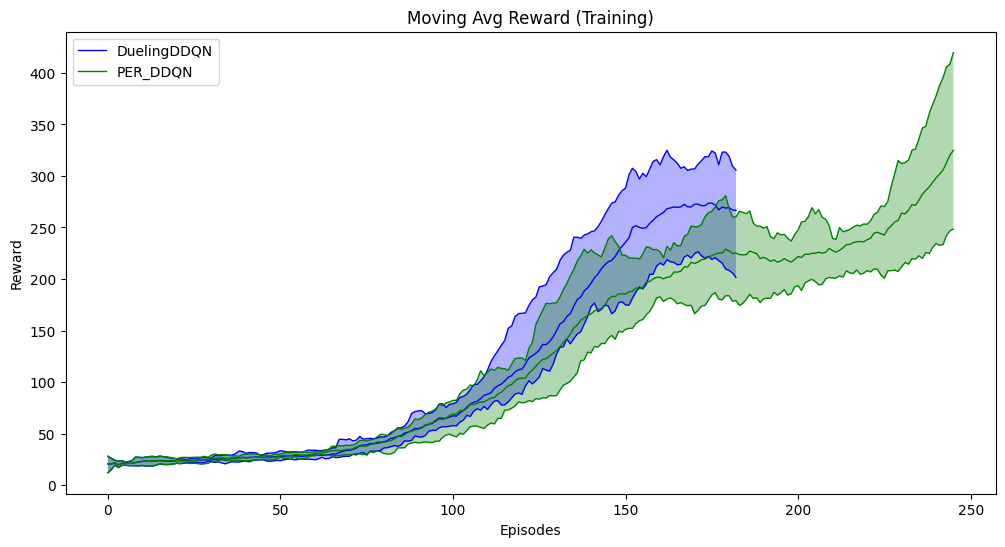

In [374]:
show_result('avg_training_reward','DuelingDDQN', dueling_ddqn_results, 'PER_DDQN', per_ddqn_results) 

Nothing really different in the evaluation plot in terms of sample complexity, but you can also see a bit more stability than previous methods.

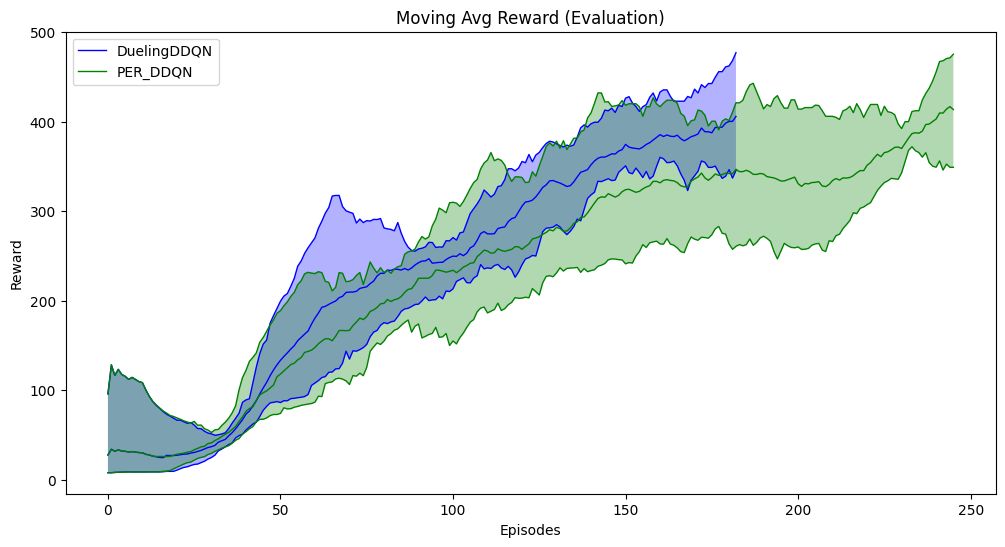

In [375]:
show_result('avg_evaluation_reward','DuelingDDQN', dueling_ddqn_results, 'PER_DDQN', per_ddqn_results) 

The real indication of sample complexity is the number of steps, not episodes, because episodes contain a variable number of steps in this environment. However, the pattern is the same. PER is more sample efficient than all previous methods

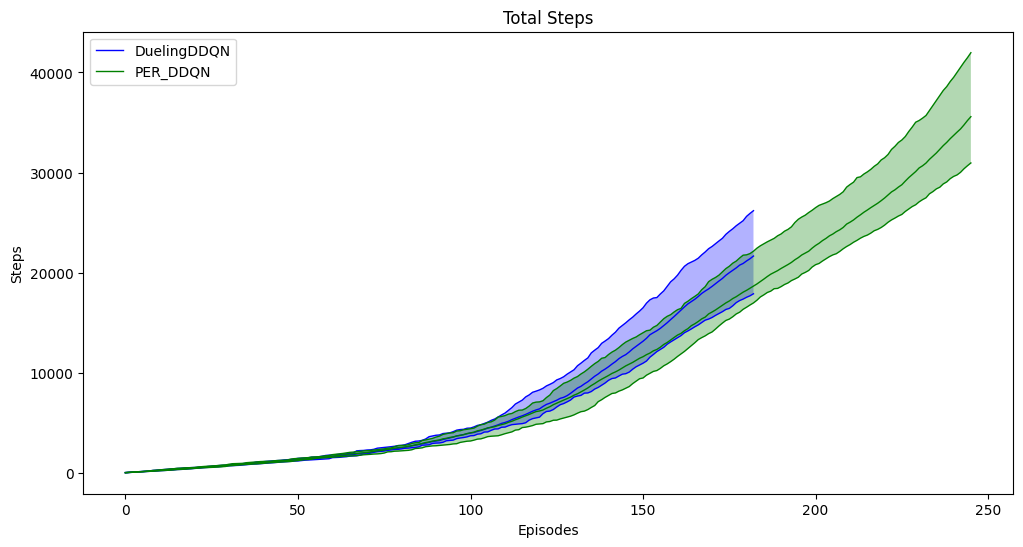

In [376]:
show_result('total_steps','DuelingDDQN', dueling_ddqn_results, 'PER_DDQN', per_ddqn_results) 

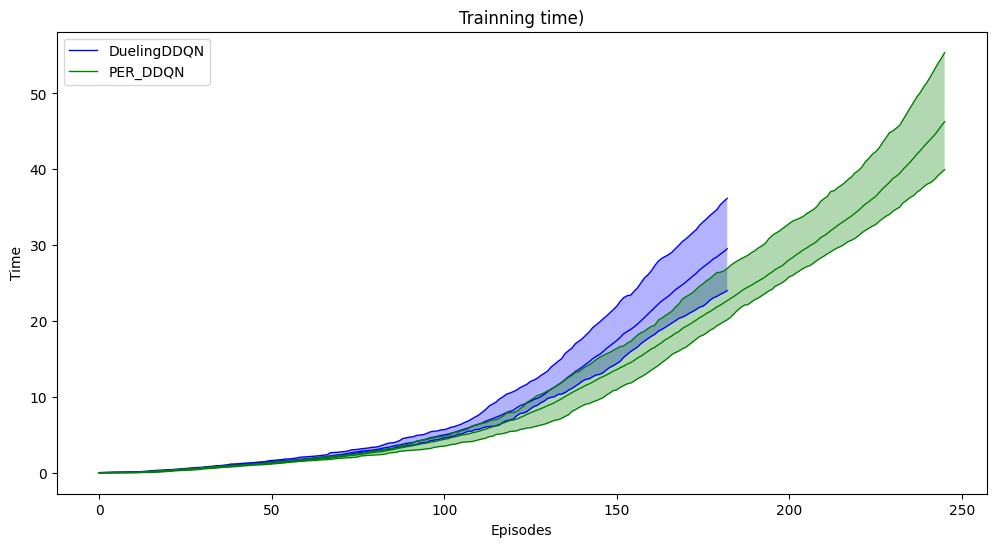

In [377]:
show_result('training_time','DuelingDDQN', dueling_ddqn_results, 'PER_DDQN', per_ddqn_results) 

But look at this! PER is much slower than dueling DDQN. But know that this is an implementation-specific issue. If you get a high quality implementation of PER, this shouldn’t happen.

## Challenges

Value-based methods are **sensitive to hyperparameters**. Try it for yourself: change any hyperparameter. You can find more values that don’t work than values that do. Second, value-based methods **assume they interact with a Markovian environment**, that the states contain all information required by the agent. This assumption dissipates as we move away from bootstrapping and value-based methods in general. 

Last, **the combination of bootstrapping, off-policy learning, and function approximator** are known conjointly as **the deadly triad**: it is known to produce **divergence**, researchers still don’t know exactly how to prevent it. A practical advice is to use target networks, replay buffers, double learning, sufficiently small learning rates (but not too small), and maybe a little bit of patience.